# ФОрмулы и вводная часть

In [1]:
import os
import scipy.io
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import warnings
warnings.simplefilter("ignore")

In [2]:
import h5py

class DigitStructFile:
    """
    MATLAB 7.3 MAT-file, Platform: GLNXA64, Created on: Mon Dec  5 20:52:58 2011 HDF5 schema 1.00 
    DigitStructFile - это просто оболочка для данных h5py. Это в основном ссылки
        inf: входной файл h5 matlab
        digitStructName Ссылка h5 на все имена файлов
        digitStructBbox Ссылка h5 на все структурированные данные
    """

    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

        
    def bboxHelper(self, attr):
        """
        bboxHelper handles the coding difference, 
        when there is exactly one bbox or an array of bbox.         
        """
        if (len(attr) > 1):
            attr = [self.inf[attr[j].item()][0][0] for j in range(len(attr))]
        else:
            attr = [attr[0][0]]
        return attr
    
    def bboxHelper_(self, attr):
        """
        bboxHelper обрабатывает разницу, 
        когда есть ровно один bbox или массив bbox-сов.
        """
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr
   
    def getName(self,n):
        # getName returns the 'name' string for the n(th) digitStruct. 
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])
    
    def getBbox(self, n):
        # getBbox returns a dict of data for the n(th) bbox.
        bb = self.digitStructBbox[n].item()
        return dict(
            height = self.bboxHelper(self.inf[bb]["height"]),
            label = self.bboxHelper(self.inf[bb]["label"]),
            left = self.bboxHelper(self.inf[bb]["left"]),
            top = self.bboxHelper(self.inf[bb]["top"]),
            width = self.bboxHelper(self.inf[bb]["width"])
        )

    def getDigitStructure(self, n):
        # getDigitStructure returns the digitStruct from the input file.     
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

    def getAllDigitStructure(self):
        # getAllDigitStructure returns all the digitStruct from the input file.     
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

    def getAllDigitStructure_ByDigit(self):
        """
        Return a restructured version of the dataset (one structure by boxed digit).
        Return a list of such dicts : 
            'filename' : filename of the samples
            'boxes' : list of such dicts (one by digit) :
            'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
            'left', 'top' : position of bounding box
            'width', 'height' : dimension of bounding box
        Note: We may turn this to a generator, if memory issues arise.
        """
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                # In metadata zero replaced to ten
                figure['label']  = 0 if pictDat[i]['label'][j] == 10 else pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [3]:
# Load data set
train_folders = './data/train'
fin = os.path.join(train_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
train_data = dsf.getAllDigitStructure_ByDigit()

In [4]:
# Load data set
test_folders = './data/test'
fin = os.path.join(test_folders, 'digitStruct.mat')
dsf_test = DigitStructFile(fin)
test_data = dsf_test.getAllDigitStructure_ByDigit()

In [5]:
# Load data set
extra_folders = './data/extra'
fin = os.path.join(extra_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
extra_data = dsf.getAllDigitStructure_ByDigit()

*Визуализируем первое изображение из тренировочного набора.*  
*Считываем его ширину и высоту.*

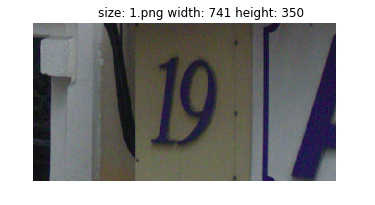

In [6]:
# Visualisation image

f, ax = plt.subplots(nrows=1, ncols=1)
fullname = os.path.join(train_folders, train_data[0]['filename'])
with Image.open(fullname) as im:
    ax.axis('off')
    str_ = f"size: {train_data[0]['filename']} width: {im.size[0]} height: {im.size[1]}"
    ax.set_title(str_, loc='center')
    ax.imshow(np.asanyarray(im))

In [7]:
# Get size source image
train_imsize = np.ndarray([len(train_data),2])
for i in np.arange(len(train_data)):
    filename = train_data[i]['filename']
    fullname = os.path.join(train_folders, filename)
    with Image.open(fullname) as im:
        train_imsize[i] = im.size
print(f"In train data set")
print(f"max width: {np.amax(train_imsize[:,0])}, max height: {np.amax(train_imsize[:,1])}")
print(f"mix width: {np.amin(train_imsize[:,0])}, mix height: {np.amin(train_imsize[:,1])}")

In train data set
max width: 876.0, max height: 501.0
mix width: 25.0, mix height: 12.0


In [8]:
test_imsize = np.ndarray([len(test_data),2])
for i in np.arange(len(test_data)):
    filename = test_data[i]['filename']
    fullname = os.path.join(test_folders, filename)
    im = Image.open(fullname)
    test_imsize[i, :] = im.size[:]

print(f"In test data set")
print(f"max width: {np.amax(test_imsize[:,0])}, max height: {np.amax(test_imsize[:,1])}")
print(f"mix width: {np.amin(test_imsize[:,0])}, mix height: {np.amin(test_imsize[:,1])}")

In test data set
max width: 1083.0, max height: 516.0
mix width: 31.0, mix height: 13.0


In [9]:
extra_imsize = np.ndarray([len(extra_data),2])
for i in np.arange(len(extra_data)):
    filename = extra_data[i]['filename']
    fullname = os.path.join(extra_folders, filename)
    im = Image.open(fullname)
    extra_imsize[i, :] = im.size[:]

print(f"In extra data set")
print(f"max width: {np.amax(extra_imsize[:,0])}, max height: {np.amax(extra_imsize[:,1])}")
print(f"mix width: {np.amin(extra_imsize[:,0])}, mix height: {np.amin(extra_imsize[:,1])}")

In extra data set
max width: 668.0, max height: 415.0
mix width: 22.0, mix height: 13.0


## Меняем размер исходного изображения на 32 х 32.  
В центре полученного изображения номер дома.  
В скрипте приложенном к набору данных «see_bboxes.mat» задана область (bbox) для каждой цифры номера дома.  
* ```aa = max(digitStruct(i).bbox(j).top+1,1);``` - Начало цифры на изображении (сверху).  
* ```bb = min(digitStruct(i).bbox(j).top+digitStruct(i).bbox(j).height, height);``` - Начало цифры на изображении (сверху) + высота цифры.  
* ```cc = max(digitStruct(i).bbox(j).left+1,1);``` - Начало цифры на изображении (слева)  
* ```dd = min(digitStruct(i).bbox(j).left+digitStruct(i).bbox(j).width, width);``` - Начало цифры на изображении (слева) + ширина цифры.

77.0
219.0
246.0
81.0
81.0
219.0
323.0
96.0
77.0
223.0
[246. 323.]
246.0
end first image


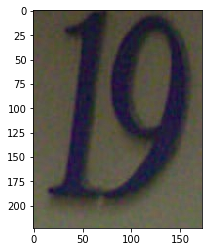

In [32]:
def generate_dataset(data, folder):
    dataset = np.ndarray([len(data), 32, 32, 1], dtype='float32')  # bbox with single digit
    labels = np.ones([len(data), 6], dtype=int) * np.nan  # ground truth for the digit on image
    
    for current_image in np.arange(len(data)):
        fullname = os.path.join(folder, data[current_image]['filename'])
        with Image.open(fullname) as im:
            
            boxes = data[current_image]['boxes']  # boxes on image with digit
            count_digit_on_image = len(boxes)  # calculate count digit on image
            
            labels[current_image, 0] = count_digit_on_image  # write digit count to labels array 
            
            # arrays with a coordinate digit bboxes
            top = np.ndarray([count_digit_on_image], dtype='float32')
            left = np.ndarray([count_digit_on_image], dtype='float32')
            height = np.ndarray([count_digit_on_image], dtype='float32')
            width = np.ndarray([count_digit_on_image], dtype='float32')
            
            for position in np.arange(count_digit_on_image):  # the position of the digits in a number
                if position < 5:
                    labels[current_image, position + 1] = boxes[position]['label']
                    # In metadata zero replaced to ten
                    if boxes[position]['label'] == 10: 
                        print(f"Warning {data[current_image]['filename']} labele == 10.")
                        labels[current_image, position + 1] = 0
                else:
                    print(f"Warning {data[current_image]['filename']} image has more than 5 digits.")
                    pass
                
                top[position] = boxes[position]['top']
                height[position] = boxes[position]['height']
                left[position] = boxes[position]['left']                
                width[position] = boxes[position]['width']
#                 print(top[position])
#                 print(height[position])
#                 print(left[position])
#                 print(width[position])
#                 imshow(np.asanyarray(im)[int(top[position]): int(top[position] + height[position]), 
#                                          int(left[position]): int(left[position] + width[position]), :])
            
            
            # Calculate coordination for bboxes all number
#             print(f"{top}")
            im_top = np.floor(np.amin(top))
            print(f"{im_top}")
            
#             print(f"{np.argmax(top)}")
#             print(f"{height[np.argmax(top)]}")
#             print(f"{im_top}")
            im_height = np.amax(top) + np.amax(height)
            print(f"{im_height}")
            
            print(f"{left}")
            im_left = np.floor(np.amin(left))
            print(f"{im_left}")
            
#             print(f"{width}")
#                     im_width = np.amax(left) + width[np.argmax(left)] - im_left
            im_width = np.floor(np.amax(left) + width[np.argmax(left)] - im_left)
#             print(f"{im_width}")
#             imshow(np.asanyarray(im)[1: 200, : , :])
            imshow(np.asanyarray(im)[int(im_top): int(im_top + im_height), 
                                     int(im_left): int(im_left + im_width), :])
            # ax.imshow(np.asanyarray(im))
            # ax[i].imshow(train_data_GCN[j,:,:])
        
        print("end first image")
        break
                          
    
generate_dataset(train_data, train_folders)
# labels = np.ones([len(train_data),6], dtype=int)
# labels

In [18]:
import PIL.Image as Image

def generate_dataset(data, folder):

    dataset = np.ndarray([len(data),32,32,1], dtype='float32')
    labels = np.ones([len(data),6], dtype=int) * 10
    for i in np.arange(len(data)):
        filename = data[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        boxes = data[i]['boxes']
        num_digit = len(boxes)
        labels[i,0] = num_digit
        top = np.ndarray([num_digit], dtype='float32')
        left = np.ndarray([num_digit], dtype='float32')
        height = np.ndarray([num_digit], dtype='float32')
        width = np.ndarray([num_digit], dtype='float32')
        for j in np.arange(num_digit):
            if j < 5: 
                labels[i,j+1] = boxes[j]['label']
                if boxes[j]['label'] == 10: labels[i,j+1] = 0
            else: print('#',i,'image has more than 5 digits.')
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']
        
        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left
        
        im_top = np.floor(im_top - 0.1 * im_height)
        im_left = np.floor(im_left - 0.1 * im_width)
        im_bottom = np.amin([np.ceil(im_top + 1.2 * im_height), im.size[1]])
        im_right = np.amin([np.ceil(im_left + 1.2 * im_width), im.size[0]])

        im = im.crop((im_left, im_top, im_right, im_bottom)).resize([32,32], Image.ANTIALIAS)
        im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        if std < 1e-4: std = 1.
        im = (im - mean) / std
        dataset[i,:,:,:] = im[:,:,:]

    return dataset, labels

train_dataset, train_labels = generate_dataset(train_data, train_folders)
print(train_dataset.shape, train_labels.shape)

test_dataset, test_labels = generate_dataset(test_data, test_folders)
print(test_dataset.shape, test_labels.shape)

extra_dataset, extra_labels = generate_dataset(extra_data, extra_folders)
print(extra_dataset.shape, extra_labels.shape)